<a href="https://colab.research.google.com/github/ReboreExplore/GAN-Papers-Implementation/blob/main/DCGAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [78]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
from torch import optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Set up the GPU

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset download and preprocessing

In [80]:
batch_size = 64
transforms = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(0.5,))
])

### Download the dataset

In [81]:
train_data = datasets.MNIST(root= './data',train=True, transform=transforms, download=True)

In [82]:
# check the shape of the images
train_data.data[0].shape

torch.Size([28, 28])

### Dataloader setup

In [83]:
trainloader = DataLoader(train_data ,batch_size = batch_size,shuffle=True)

### Visualize the dataset 

In [84]:
def show_batch(trainloader):
  for i, (images,_) in enumerate(trainloader):
    if i < 1:
      fig, ax = plt.subplots(figsize=(8, 8))
      grid = torchvision.utils.make_grid(images, nrow=16, normalize=True)
      np_grid = grid.numpy()
      np_grid = np.transpose(np_grid, (1, 2, 0))
      plt.imshow(np_grid)

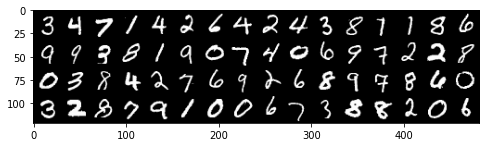

In [85]:
# Visualize images
show_batch(trainloader)

## Models

### Initializations

In [86]:
num_filters = [512, 256, 128]
image_dim = (batch_size,1,28,28)
latent_dims = 100

### Generator Model

In [87]:
class Generator(nn.Module):
  def __init__(self,latent_dim,num_filters,output_dim):
    super(Generator,self).__init__()
    #Input Projection
    self.input_layer = nn.Sequential(
    nn.Linear(latent_dim,256*16*16),
    nn.ReLU()
    )
    # Hidden Layers
    self.hidden_layers = nn.Sequential()
    for i in range(len(num_filters)):
      if i == 0:
          tconv = nn.ConvTranspose2d(256, num_filters[i], kernel_size=4, stride=1, padding=0)
      else:
          tconv = nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=1, padding=0)

      tconv_name = 'tconv' + str(i + 1)
      self.hidden_layers.add_module(tconv_name, tconv)

      # Weight and bias initialization
      nn.init.normal_(tconv.weight, mean=0.0, std=0.02)
      nn.init.constant_(tconv.bias, 0.0)

      # Batch normalization
      if i != 0:
          batch_norm = nn.BatchNorm2d(num_filters[i])
          bn_name = 'bn' + str(i + 1)
          self.hidden_layers.add_module(bn_name, batch_norm)

      # Activation
      activation = nn.ReLU(0.2)
      act_name = 'act' + str(i + 1)
      self.hidden_layers.add_module(act_name, activation)

    # Output Layer
    self.output_layer = torch.nn.Sequential()
    # Deconvolutional layer
    out = nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
    self.output_layer.add_module('out', out)
    
    # Weight and Bias initialization
    torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
    torch.nn.init.constant_(out.bias, 0.0)
    
    # Activation
    output_activation = nn.Tanh()
    self.output_layer.add_module('act', output_activation)


  def forward(self, x):
    x = self.input_layer(x)
    x = x.view(x.size(0),256,16,16)
    x = self.hidden_layers(x)
    out = self.output_layer(x)
    return out

### Test the generator model

In [101]:
gen_model = Generator(latent_dim,num_filters,1)
gen_model =gen_model.to(device)
print(gen_model)

Generator(
  (input_layer): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (tconv1): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (act1): ReLU(inplace=True)
    (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
  )
  (output_layer): Sequential(
    (out): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
    (act): Tanh()
  )
)


*For ConvTranspose2D layers*

**H_out** = strides* (input_size-1)+ kernal_size -(2 * padding)

For this model =  [100x1] -> [256x16x16] -> [512x19x19] -> [256x22x22] -> [128x25x25] -> [1x28x28]

In [102]:
# unit test
test_image = torch.randn(1,100)
img =gen_model(test_image.to(device))
img.shape

torch.Size([1, 1, 28, 28])

### Discriminator Model

In [90]:
class Discriminator(nn.Module):
  def __init__(self,input_dim,num_filters,output_dim):
    super(Discriminator,self).__init__()
    # Hidden Layers
    self.hidden_layers = nn.Sequential()
    for i in range(len(num_filters)):
      if i == 0:
          conv = nn.Conv2d(input_dim, num_filters[i], kernel_size=3, stride=1, padding='same')
      else:
          conv = nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=3, stride=1, padding='same')

      conv_name = 'conv' + str(i + 1)
      self.hidden_layers.add_module(conv_name, conv)

      # Weight and bias initialization
      nn.init.normal_(conv.weight, mean=0.0, std=0.02)
      nn.init.constant_(conv.bias, 0.0)

      # Batch normalization
      if i != 0:
          batch_norm = nn.BatchNorm2d(num_filters[i])
          bn_name = 'bn' + str(i + 1)
          self.hidden_layers.add_module(bn_name, batch_norm)

      # Activation
      activation = nn.LeakyReLU(0.2)
      act_name = 'act' + str(i + 1)
      self.hidden_layers.add_module(act_name, activation)

    # Output Layer
    self.lastconv_layer = torch.nn.Sequential()
    # convolutional layer
    outconv = nn.Conv2d(num_filters[-1], 128 , kernel_size=4, stride=2, padding=1)
    self.lastconv_layer.add_module('convout', outconv)
    
     # Weight and Bias initialization
    torch.nn.init.normal_(outconv.weight, mean=0.0, std=0.02)
    torch.nn.init.constant_(outconv.bias, 0.0)
    
    self.output_layer = torch.nn.Sequential()
    # Linear Layers
    outlin = nn.Linear(128*14*14,1)
    self.output_layer.add_module('outlin', outlin)
   
    # Activation
    output_activation = nn.Sigmoid()
    self.output_layer.add_module('act', output_activation)


  def forward(self, x):
    x = self.hidden_layers(x)
    x = self.lastconv_layer(x)
    x = x.view(x.size(0),-1)
    x = self.output_layer(x)

    return x

### Check the discriminator model

In [103]:
disc_model = Discriminator(1,num_filters[::-1],1)
disc_model.to(device)
disc_model

Discriminator(
  (hidden_layers): Sequential(
    (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (act1): LeakyReLU(negative_slope=0.2)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): LeakyReLU(negative_slope=0.2)
    (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): LeakyReLU(negative_slope=0.2)
  )
  (lastconv_layer): Sequential(
    (convout): Conv2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (output_layer): Sequential(
    (outlin): Linear(in_features=25088, out_features=1, bias=True)
    (act): Sigmoid()
  )
)

*For Conv2D layers*

**n_out** = (input_size + (2*padding) - kernal_size)/stride + 1 

For this model = [1x28x28] -> [512x28x28] -> [256x28x28] -> [128x28x28] -> [128x14x14] -> [1,1]

In [92]:
# unit test
disc_test = torch.randn(20,1,28,28) # test with a batch size of 20
pred = disc_model(disc_test.to(device))
pred.shape

torch.Size([20, 1])

## Training 

### Initialization

In [105]:
train_steps = 1000
disc_steps = 1 
gen_steps = 2

### Set up helper functions

In [106]:
# helper function to get the noise signals
def get_noise_samples(batch_size, dims):
    return torch.randn([batch_size, dims])

In [107]:
# Applying label smoothing
def get_real_labels(batch_size):
  real_labels = torch.randint(8,10,(batch_size,1))
  return torch.mul(real_labels,0.1)

def get_fake_labels(batch_size):
  fake_labels = torch.randint(0,2,(batch_size,1))
  return torch.mul(fake_labels,0.1)

In [108]:
# Discriminator Train function
def disc_train(loader,latent_dims,disc,gen,batch_size,criterion,disc_optimizer,device):
  real_data, _ = next(iter(loader))
  real_data = real_data.to(device)
  noise_vector = get_noise_samples(batch_size, latent_dims)
  noise_vector = noise_vector.to(device)
  
  real_label_pred = disc(real_data)
  fake_data = gen(noise_vector)
  fake_label_pred = disc(fake_data.detach())
  
  real_label = get_real_labels(batch_size).to(device)
  fake_label = get_fake_labels(batch_size).to(device)
  # disc_loss = - torch.mean((torch.log(real_image)) +(torch.log(1 - fake_image)))
  
  real_loss = criterion(real_label_pred,real_label)
  fake_loss = criterion(fake_label_pred,fake_label)

  disc_loss = real_loss + fake_loss
  
  disc_optimizer.zero_grad()
  disc_loss.backward()
  disc_optimizer.step()
  
  return disc_loss.item()

In [109]:
# Generator Train Function
def gen_train(latent_dims,disc,gen,batch_size,criterion,gen_optimizer,device):
  noise_vector = get_noise_samples(batch_size, latent_dims)
  noise_vector = noise_vector.to(device)
  gen_image = gen(noise_vector)
  fake_but_real_pred = disc(gen_image)

  fake_but_real_label = get_real_labels(batch_size).to(device)

  # gen_loss = - torch.mean(torch.log(fake_but_real_pred))
  gen_loss = criterion(fake_but_real_pred, fake_but_real_label)
  
  gen_optimizer.zero_grad()
  gen_loss.backward()
  gen_optimizer.step()

  return gen_loss.item()


### Train loop

In [111]:
def train_loop(disc, gen, epochs, disc_steps, gen_steps, loader, batch_size, latent_dims,device):
    
    disc_optimizer = optim.Adam(disc.parameters(),betas=(0.5, 0.999), lr = 0.0002)
    gen_optimizer = optim.Adam(gen.parameters(),betas=(0.5, 0.999), lr = 0.0002) 
    criterion = nn.BCELoss()
    
    pbar = tqdm(range(train_steps))
    total_disc_loss = []
    total_gen_loss = []

    for i in pbar:
      
      disc_loss_per_k = []
      gen_loss_per_k = []
      
      # discriminator training
      for j in range(disc_steps):
        disc_loss = disc_train(loader,latent_dims,disc,gen,batch_size,criterion,disc_optimizer,device)
        disc_loss_per_k.append(disc_loss)
     
     # generator training
      for k in range(gen_steps):
        gen_loss = gen_train(latent_dims,disc,gen,batch_size,criterion,gen_optimizer,device)
        gen_loss_per_k.append(gen_loss)
    
      total_disc_loss.append(np.mean(disc_loss_per_k))
      total_gen_loss.append(np.mean(gen_loss_per_k))
      
      pbar.set_description(f"D_loss: {np.mean(total_disc_loss):.4f}, G_loss: {np.mean(total_gen_loss):.4f}")
    
    return total_disc_loss,total_gen_loss

In [116]:
disc_loss, gen_loss = train_loop(disc_model, gen_model, train_steps, disc_steps, gen_steps, trainloader, batch_size, latent_dim,device)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Check and visualize output

In [ ]:
# check output
test_noise_vectors = get_noise_samples(25, 100)
test_noise_vectors = test_noise_vectors.to(device)
gen_images = gen_model(test_noise_vectors)
print(gen_images.shape)
grid = torchvision.utils.make_grid(gen_images, nrow=5, normalize=True)

np_grid = grid.cpu().numpy()
np_grid = np.transpose(np_grid, (1, 2, 0))
plt.imshow(np_grid)

In [114]:
sample_size = 5
disc_loss = disc_loss[0::sample_size]
gen_loss = gen_loss[0::sample_size]

### Plot the discriminator and generator loss

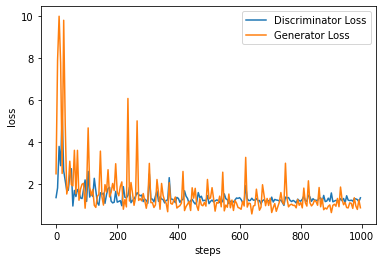

In [115]:
# plotting function
epochs = [i for i in np.arange(0,train_steps,sample_size)]
plt.plot(epochs, disc_loss, label = "Discriminator Loss")
plt.plot(epochs, gen_loss, label = "Generator Loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()
plt.show()